In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as wb
import scipy.optimize as spo
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [15]:
def get_data(start, end, symbols):
    dates = pd.date_range(start,end)
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_temp = wb.DataReader(symbol,'yahoo',start, end, pause=1)
        df[symbol]=df_temp['Close']
    
    df = df.dropna(axis=0)
    return df

In [85]:
#need to iterate to the correct key!
def plot_df(df, title, ax=None):
    ax = ax or plt.gca()
    style.use('ggplot')
    ax = df.plot(title=title, fontsize=12, ax=ax)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    return ax

In [8]:
#need to iterate to the correct key!
def plot_rolling(df,key,windows,title):
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    
    for symbol in key:
        mean = pd.rolling_mean(df[symbol],windows)
        std = pd.rolling_std(df[symbol],windows)
        upper = mean+std
        lower = mean-std

        style.use('ggplot')
        upper.plot(label=symbol+':upper band',ax=ax)
        lower.plot(label=symbol+':lower band',ax=ax)
        
    ax.legend()
    plt.show()

In [64]:
#daily_return = (price[i]-price[i-1])-1
def daily_return(df):
    daily_returns = df.copy()
    daily_return = (daily_returns/daily_returns.shift())-1
    daily_return.ix[0,0]=0
    return daily_return

In [10]:
def sharpe_ratio(daily_return,daily_rf=0,samples_per_year=252):
    sr = ((daily_return - daily_rf).mean()/daily_return.std()) * np.sqrt(samples_per_year)
    return sr

In [75]:
# calculate all of the index here, cumulative return, average daily return, Sharpe Ratio
def calculate_portfolio(df, allo):
    ndf = df/df.ix[0]
    df = allo * ndf
    tdf = df.sum(axis=1)
    cr = (tdf[-1]/tdf[0])-1
    dr = daily_return(tdf)
    sr = sharpe_ratio(dr)
    return cr, tdf, dr, sr

In [80]:
# the goal for optimize the model is to find the maximum sharp ratio 
# calculate the sharp ratio based on allocates of each stock we have
# not hard to do, just need to figure out the structure of the model
# and plot the result！

def optimize_allo_sp(df):
    num = df.shape[1]
    allo = np.zeros((num,1),float)
    allo = (1/num) * (allo+1)
    allo = allo.transpose()

    #df = allo * df
    cons = ({'type': 'eq', 'fun': lambda x:  1.0-np.sum(x)})
    bnds = [[0,1] for _ in df.columns]
    print(df.columns)
    result = spo.minimize(model, allo, 
                          method='SLSQP', args = (df,),
                          bounds = bnds, constraints = cons, options={'disp':True})
    allo = result.x
    return allo

In [76]:
def model(allo, df):
    cr, tdf, dr, sr = calculate_portfolio(df, allo)
    summ = sr * -1
    return summ

Index(['TSLA', 'GOOG'], dtype='object')
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.29896957993526135
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3


In [73]:
allocs

array([ 0.,  1.])

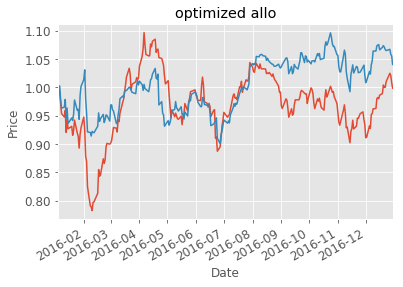

In [86]:
start = pd.to_datetime('2016-01-01')
end = pd.to_datetime('2016-12-31')
symbols = ['TSLA','GOOG']
#df = get_data(start,end,symbols)
#df = df.dropna()
#print(df)

#plot_df(df, title='Market Trend')
#plot_rolling(df,key=symbols,windows=20,title='Rolling band')
allo = [0.5,0.5]
cr, ndf, dr, sr = calculate_portfolio(df,allo)
ax = plot_df(ndf, title='initial allo')
allo = [0,1]
cr, ndf, dr, sr = calculate_portfolio(df,allo)
plot_df(ndf, title='optimized allo',ax=ax)
#print('Sharpe Ratio',sr)


,TSLA,GOOG
2016-01-04,111.705002,370.920013
2016-01-05,111.714997,371.290008
2016-01-06,109.519997,371.809998
2016-01-07,107.824997,363.195008
2016-01-08,105.500000,357.234985
2016-01-11,103.925003,358.015015
2016-01-12,104.985000,363.035004
2016-01-13,100.154999,350.279999
2016-01-14,103.089996,357.359985
2016-01-15,102.495002,347.225006
